#Часть1

## Описание данных:

Исследуемая страна - Австралия

1. cpi - Темп инфляции, рассчитанный на основе ИПЦ в % (с сезонной корректировкой, квартальный): https://www.rba.gov.au/statistics/tables/xls/g01hist.xlsx?v=2024-11-15-16-03-14
2. cpif_xe - Темп инфляции с исключением волатильных элементов в % (сезонно скорректированный, квартальный): https://www.rba.gov.au/statistics/tables/xls/g01hist.xlsx?v=2024-11-15-16-03-14
3. cpi_pred - Ожидания инфляции среди бизнеса в % (аннуализированные, квартальные) - https://www.rba.gov.au/statistics/tables/xls/g03hist.xlsx?v=2024-11-17-13-25-05
4. real_gpt - Реальный ВВП в миллионах $ (квартальный): https://www.rba.gov.au/statistics/tables/xls/h01hist.xlsx?v=2024-11-25-20-18-31
5. cli - Композитный опережающий индикатор (CLI) нормализованный: https://fred.stlouisfed.org/series/AUSLOLITONOSTSAM#0

https://www.rba.gov.au/statistics/tables/

<center>
<img src="https://i.ytimg.com/vi/WUS34ngxjy0/maxresdefault.jpg" height="300">

</center>

## Предобработочка

In [42]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [43]:
df = pd.read_excel('/content/австралия_дз_макра.xlsx')
print(df.shape)
df.info()

(138, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   data                    138 non-null    datetime64[ns]
 1   cpi_not_annualized      137 non-null    float64       
 2   cpif_xe_not_annualized  137 non-null    float64       
 3   cpi_pred                137 non-null    float64       
 4   real_gdp                138 non-null    int64         
 5   cli                     137 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 6.6 KB


### Переведем темп совокупной (headline) инфляции и темп базовой (core) инфляции в аннуализированные показатели

In [44]:
df['cpi'] = ((1 + df['cpi_not_annualized'] / 100) ** 4 - 1) * 100
df['cpif_xe'] = ((1 + df['cpif_xe_not_annualized'] / 100) ** 4 - 1) * 100

# удаляем неаннуализированные столбцы
df.drop(['cpi_not_annualized', 'cpif_xe_not_annualized'], axis=1, inplace=True)

### Найдем аннуализированный квартальный темп прироста реального ВВП в % с помощью показателя реального ВВП

In [45]:
df.head(3)

,data,cpi_pred,real_gdp,cli,cpi,cpif_xe
0,1989-06-01,NaN,229071,NaN,NaN,NaN
1,1989-09-01,4.8,230987,99.117,9.522295,6.555245
2,1989-12-01,3.5,230362,98.362,6.975374,6.555245


In [46]:
df['quarterly_growth'] = df['real_gdp'].pct_change()  # Изменение от квартала к кварталу

# # Рассчитываем аннуализированный квартальный темп прироста
df['real_gdp_growth_rate'] = (1 + df['quarterly_growth']) ** 4 - 1  # Аннуализированный темп
df['real_gdp_growth_rate'] = df['real_gdp_growth_rate'] * 100  # Переводим в проценты
df.drop('quarterly_growth', axis=1, inplace=True)

# # удаляем первую строку, она нам больше не нужна
df = df.dropna()

df.head(3)

,data,cpi_pred,real_gdp,cli,cpi,cpif_xe,real_gdp_growth_rate
1,1989-09-01,4.8,230987,99.117,9.522295,6.555245,3.387898
2,1989-12-01,3.5,230362,98.362,6.975374,6.555245,-1.077927
3,1990-03-01,4.6,232145,97.700,6.555245,6.975374,3.132127


<center>
<img src="https://funnyfoto.org/wp-content/uploads/2018/03/meanwhile-russian-funny-people-images-12_03_02_2018.jpg" height="400">

</center>

### Рассчитаем потенциальный ВВП (с помощью метода фильтра Ходрика-Прескотта)

In [47]:
from statsmodels.tsa.filters.hp_filter import hpfilter

# зададим коэффициент сглаживания для квартальных данных
alpha = 1600

# Применяем фильтр Ходрика-Прескотта с λ=1600 для квартальных данных
cycle, trend = hpfilter(df['real_gdp'], lamb=alpha)
trend
# заносим данные о потенциальном ввп
df['potential_gdp'] = trend

### Рассчитаем разрыв выпуска

In [48]:
df['output_gap'] = (df['real_gdp'] - df['potential_gdp']) / df['potential_gdp'] * 100

# удаляем потенциальный и реальный ВВП
df.drop(['potential_gdp', 'real_gdp'], axis=1, inplace=True)

## Номер 10

(15 баллов) Дополнительные баллы можно получить, если изначальные временные ряды очистить от сезонности, а так же проверить все ряды на наличие единичного корня (если ряд не стационарен, то рассчитать первые разности)


  Это необязательный пункт, который требует самостоятельного изучения некоторых элементов работы с временными рядами. В сети Интернет много готовых, написанных кодов, которые позволяют очищать данные от сезонности, а так же проверять ряд на наличие единичного корня.

#### Очищение от сезонности

Большинство наших рядов уже очищенно от сезонности, так как они изначально идут seasonally adjusted(указано в источнике). Но два ряда: инфляционные ожидания (cpi_pred) и индекс экономической активности (cli) требуют обработки:

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Удаляем сезонность
seasonal_period = 4
for col in ['cpi_pred', 'cli']:
    df[col] = df[col] - seasonal_decompose(df[col], model='additive', period=seasonal_period).seasonal
df[['cpi_pred', 'cli']].head(3)

,cpi_pred,cli
1,4.935812,99.070145
2,3.550585,98.392664
3,4.716427,97.745036



#### Проверка на наличие единичного корня
Для проверки стационарности проведем обобщенный тест Дикки-Фуллера на наличие единичных корней. Для этого в модуле statsmodels есть функция adfuller():

In [50]:
from statsmodels.tsa.stattools import adfuller
np.random.seed(42)
columns_to_test = ['cpi_pred', 'cli', 'cpi', 'cpif_xe', 'real_gdp_growth_rate', 'output_gap']

#функция для вывода p-value и test stat
def adf_test(series):
    result = adfuller(series)
    return {'Test Statistic': result[0], 'p-value': result[1]}

# adfuller не работает для датафрейма, делаем цикл для прохождения каждого столбца по отдельньсти
for column in columns_to_test:
    results = adf_test(df[column])

    print(f"Results for {column}:")
    print('Test Statistic:', results['Test Statistic'])
    print('p-value:', results['p-value'])

    if results['p-value'] < 0.05:
        print("Reject null hypothesis: The series is likely stationary.")
    else:
        print("Fail to reject null hypothesis: The series is likely non-stationary.")

    print("\n")

Results for cpi_pred:
Test Statistic: -3.9880668865419544
p-value: 0.0014743017965261982
Reject null hypothesis: The series is likely stationary.


Results for cli:
Test Statistic: -5.797653951091687
p-value: 4.710771576630561e-07
Reject null hypothesis: The series is likely stationary.


Results for cpi:
Test Statistic: -5.806781199288466
p-value: 4.49722421045524e-07
Reject null hypothesis: The series is likely stationary.


Results for cpif_xe:
Test Statistic: -4.717592598660906
p-value: 7.797698954895505e-05
Reject null hypothesis: The series is likely stationary.


Results for real_gdp_growth_rate:
Test Statistic: -4.6792726024381315
p-value: 9.203016677043135e-05
Reject null hypothesis: The series is likely stationary.


Results for output_gap:
Test Statistic: -6.098722363725598
p-value: 9.954479789782343e-08
Reject null hypothesis: The series is likely stationary.




In [51]:
df.set_index('data', inplace = True)

## Что с корреляцией?

In [52]:
df.corrwith(df.cpi)

,0
cpi_pred,0.565574
cli,-0.223349
cpi,1.000000
cpif_xe,0.720083
real_gdp_growth_rate,0.169021
output_gap,0.363970


##Номер 2

Основные описательные статистики найденных временных рядов (минимум, максимум, медиана, мода, среднее, стандартное отклонение, асимметрия)

In [53]:
description =  df.iloc[:, -6:].describe().transpose()

# Добавляем дополнительные статистики
description['median'] =  df.iloc[:, -6:].median()
description['mode'] =  df.iloc[:, -6:].mode().iloc[0]  # мода, берем первое значение
description['skew'] =  df.iloc[:, -6:].skew() # коэф. ассиметрии

np.round(description, 2)

,count,mean,std,min,25%,50%,75%,max,median,mode,skew
cpi_pred,137.0,1.89,0.97,-0.10,1.24,1.65,2.24,5.00,1.65,0.94,1.18
cli,137.0,99.90,1.01,96.79,99.45,99.97,100.56,102.80,99.97,99.18,-0.27
cpi,137.0,2.80,2.56,-7.39,1.61,2.42,3.65,16.09,2.42,2.42,1.06
cpif_xe,137.0,2.75,1.70,-5.10,2.02,2.42,3.24,8.67,2.42,2.02,0.51
real_gdp_growth_rate,137.0,2.97,3.86,-24.13,1.54,2.90,4.12,15.66,2.90,-24.13,-1.90
output_gap,137.0,-0.00,1.10,-7.05,-0.44,0.11,0.67,2.61,0.11,-7.05,-2.39


## Номер 3

Первая спецификация - это регрессия, которая прогнозирует инфляцию ИПЦ на один год вперед, используя отставания от ИПЦ (в частности, прошлые значения квартального годового процентного изменения ИПЦ).1 Мы оцениваем эту регрессию рекурсивным образом, начиная с выборки, которая включает в себя 40 кварталов данных и добавляет дополнительную точку данных к выборке в каждом последующем квартале.2 Этот подход эквивалентен тому, что инфляция в следующем году является функцией всех прошлых значений инфляции за 4 кварталов до этого. Регрессионный анализ вычисляет параметры этой функции.

Вторая спецификация прогнозирует инфляцию ИПЦ на один год вперед, используя наивную спецификацию, в которой прогноз на предстоящий год - это просто темпы роста ИПЦ за последние четыре квартала. Например, четырехквартальный темп роста ИПЦ составляет 1,2 процента в третьем квартале 2010 года. Используя наивный метод, 1,2 процента становятся нашим прогнозом инфляции на следующие четыре квартала (до третьего квартала 2011 года). Этот подход эквивалентен тому, чтобы сказать, что инфляция в предстоящем году, скорее всего, будет такой же, как и в прошлом году до этого момента.

In [54]:
df.head(3)

,cpi_pred,cli,cpi,cpif_xe,real_gdp_growth_rate,output_gap
data,,,,,,
1989-09-01,4.935812,99.070145,9.522295,6.555245,3.387898,2.605800
1989-12-01,3.550585,98.392664,6.975374,6.555245,-1.077927,1.867935
1990-03-01,4.716427,97.745036,6.555245,6.975374,3.132127,2.195098


### Наивный прогноз дефолт. Спецификация 2


In [55]:
def naive_forecast(df, name, to_pred):
  df['pred'] = df[name].rolling(window=4).mean().shift(1)
  df = df.dropna()
  rmse = mean_squared_error(df[to_pred], df['pred'])**0.5
  return df, rmse


cpi_df_naive = df[['cpi', 'cpi_pred']]
name = 'cpi'
cpi_df_naive_2, rmse_spec_2 = naive_forecast(cpi_df_naive, name, name)
y_pred_spec_2 = cpi_df_naive_2.pred
print(f'RMSE при наивном прогнозе CPI = {rmse_spec_2}')

RMSE при наивном прогнозе CPI = 2.530792850802589


### Регрессия прогноз дефолт. Спецификация 1


In [56]:
import statsmodels.api as sm

def reg_inflation(df, column_name, to_pred, x = ''):
  for i in range(4, 0, -1):
      df[f'{column_name}_minus_{i}'] = df[column_name].shift(i)
  df[f'{column_name}_t'] = df[column_name]

  for i in range(1, 4):
      df[f'delta_t_minus_{i}'] = df[f'{column_name}_minus_{i}'] - df[f'{column_name}_minus_{i+1}']
  df[f'delta_t'] = df[f'{column_name}_t'] - df[f'{column_name}_minus_1']
  df[f'{to_pred}_plus_4'] = df[to_pred].shift(-4)
  df['target'] = df[f'{to_pred}_plus_4'] - df[to_pred]
  df.drop(column_name, axis = 1, inplace = True)

  if x != '':
    df[f'{x}_t_minus_1'] = df[x].shift(1)

  df = df.dropna()
  return df

In [57]:
cpi_reg_df = df[['cpi']]
cpi_reg_df = reg_inflation(cpi_reg_df, 'cpi', 'cpi')
X = cpi_reg_df[['delta_t', 'delta_t_minus_1', 'delta_t_minus_2','delta_t_minus_3']]
y = cpi_reg_df['target']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

y_pred_first = model.predict(X)
rmse_spec_1 = mean_squared_error(y, y_pred_first)**0.5
print(f'RMSE при регрессионом прогнозе CPI = {rmse_spec_1}')
print(f'R^2 при регрессионом прогнозе CPI = {model.rsquared}')

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     12.68
Date:                Mon, 25 Nov 2024   Prob (F-statistic):           1.11e-08
Time:                        20:36:13   Log-Likelihood:                -311.53
No. Observations:                 129   AIC:                             633.1
Df Residuals:                     124   BIC:                             647.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0560      0.243     

## Номер 4
Повторите пункт (3), однако вместо показателя совокупного ИПЦ (headline CPI), используйте показатель базовый ИПЦ (core CPI). Результаты оценки представьте в виде сводной таблицы. Можете продлить таблицу из пункта (3) или составить новую.

### Наивный прогноз для базовой инфляции

In [58]:
# скользящая средняя

cpi_df_naive = df[['cpi', 'cpif_xe']]

name = 'cpif_xe'
to_pred = 'cpi'
cpi_df_naive_2_core, rmse_spec_2_core = naive_forecast(cpi_df_naive, name, to_pred)
y_pred_spec_2_core = cpi_df_naive_2_core.pred
print(f'RMSE при наивном прогнозе CPI = {rmse_spec_2_core}')

RMSE при наивном прогнозе CPI = 2.5213034803547627


### Регрессия прогноз для базовой инфляции

In [59]:
# регрессионный прогноз
cpi_df_naive = df[['cpi', 'cpif_xe']]

cpi_reg_df = reg_inflation(cpi_df_naive, 'cpif_xe', 'cpi')
X = cpi_reg_df[['delta_t', 'delta_t_minus_1', 'delta_t_minus_2','delta_t_minus_3']]
y = cpi_reg_df['target']

X = sm.add_constant(X)
model_1 = sm.OLS(y, X).fit()
print(model_1.summary())

y_pred_first_core = model_1.predict(X)
rmse_spec_1_core = mean_squared_error(y, y_pred_first_core)**0.5
print(f'RMSE при регрессионом прогнозе CPIF_XE = {rmse_spec_1_core}')
print(f'R^2 при регрессионом прогнозе CPIF_XE = {model_1.rsquared}')

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     4.672
Date:                Mon, 25 Nov 2024   Prob (F-statistic):            0.00151
Time:                        20:36:13   Log-Likelihood:                -324.59
No. Observations:                 129   AIC:                             659.2
Df Residuals:                     124   BIC:                             673.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0638      0.269     

## Номер 5

### Наивный прогноз по ожиданиям. Спецификация 4



In [60]:
# скользящая средняя

cpi_df_naive = df[['cpi', 'cpi_pred']]

name = 'cpi_pred'
to_predict = 'cpi'
cpi_df_naive_4, rmse_spec_4 = naive_forecast(cpi_df_naive, name, to_predict)
y_pred_spec_4 = cpi_df_naive_4.pred
print(f'RMSE при наивном прогнозе CPI = {rmse_spec_4}')

RMSE при наивном прогнозе CPI = 2.4766388791996614


### Регрессия прогноз по ожиданиями. Спецификация 3

In [61]:
forecast_df = df[['cpi', 'cpi_pred']]
forecast_df['cpi_pred_t_plus_4'] = forecast_df['cpi_pred'].shift(4)
forecast_df = forecast_df.dropna()
forecast_df

X = forecast_df['cpi_pred_t_plus_4']
y = forecast_df['cpi']
X = sm.add_constant(X)

model_3 = sm.OLS(y, X).fit()
print(model_3.summary())
y_pred_3 = model_3.predict(X)
rmse_spec_3 = mean_squared_error(y, y_pred_3)**0.5
print(f'RMSE при регрессионом прогнозе EXP = {rmse_spec_3}')
print(f'R^2 при регрессионом прогнозе CPIF_XE = {model_3.rsquared}')

                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.523
Date:                Mon, 25 Nov 2024   Prob (F-statistic):              0.219
Time:                        20:36:13   Log-Likelihood:                -306.44
No. Observations:                 133   AIC:                             616.9
Df Residuals:                     131   BIC:                             622.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.1393      0.46

## Номер 6

### Регрессия прогноз. Спецификация 5



$$
\pi_{t+4}^4 - \pi_t = \alpha + \beta_1 (\pi_t - \pi_{t-1}) + \beta_2 (\pi_{t-1} - \pi_{t-2}) + \beta_3 (\pi_{t-2} - \pi_{t-3}) + \beta_4 (\pi_{t-3} - \pi_{t-4}) + \gamma (x_{t-1}) + \varepsilon_t
$$

x_(t-1) – мера экономической активности в предыдущем квартале. За меру экономической активности примите разрыв выпуска реального ВВП. Разрыв выпуска рассчитайте с помощью фильтра Ходрика-Прескотта. Самостоятельно ознакомьтесь с процедурой расчета разрыва выпуска при помощи ХП фильтра, найдите соответствующий код в сети Интернет. Дайте ссылку.

In [62]:
df.head(3)

,cpi_pred,cli,cpi,cpif_xe,real_gdp_growth_rate,output_gap
data,,,,,,
1989-09-01,4.935812,99.070145,9.522295,6.555245,3.387898,2.605800
1989-12-01,3.550585,98.392664,6.975374,6.555245,-1.077927,1.867935
1990-03-01,4.716427,97.745036,6.555245,6.975374,3.132127,2.195098


In [63]:
kek = df[['cpi', 'output_gap']]
kek = reg_inflation(kek, 'cpi', 'cpi',  x = 'output_gap')
X = kek[['delta_t', 'delta_t_minus_1', 'delta_t_minus_2','delta_t_minus_3','output_gap_t_minus_1']]
y = kek['target']

X = sm.add_constant(X)
model_5 = sm.OLS(y, X).fit()
print(model_5.summary())

y_pred_5 = model_5.predict(X)
rmse_spec_5 = mean_squared_error(y, y_pred_5)**0.5
print(f'RMSE при регрессионом прогнозе output_gap = {rmse_spec_5}')
print(f'R^2 при регрессионом прогнозе output_gap = {model_5.rsquared}')

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     11.16
Date:                Mon, 25 Nov 2024   Prob (F-statistic):           7.05e-09
Time:                        20:36:13   Log-Likelihood:                -309.53
No. Observations:                 129   AIC:                             631.1
Df Residuals:                     123   BIC:                             648.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0200 

### Регрессия прогноз. Спецификация 6

x_(t-1) – мера экономической активности в предыдущем квартале. За меру экономической активности примите аннуализированный квартальный темп прироста реального ВВП.

In [64]:
kek = df[['cpi', 'real_gdp_growth_rate']]
kek = reg_inflation(kek, 'cpi', 'cpi', x = 'real_gdp_growth_rate')
X = kek[['delta_t', 'delta_t_minus_1', 'delta_t_minus_2','delta_t_minus_3','real_gdp_growth_rate_t_minus_1']]
y = kek['target']

X = sm.add_constant(X)
model_6 = sm.OLS(y, X).fit()
print(model_6.summary())

y_pred_6 = model_6.predict(X)
rmse_spec_6 = mean_squared_error(y, y_pred_6)**0.5
print(f'RMSE при регрессионом прогнозе real_gdp_growth_rate = {rmse_spec_6}')
print(f'R^2 при регрессионом прогнозе real_gdp_growth_rate = {model_6.rsquared}')

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     10.46
Date:                Mon, 25 Nov 2024   Prob (F-statistic):           2.20e-08
Time:                        20:36:14   Log-Likelihood:                -310.79
No. Observations:                 129   AIC:                             633.6
Df Residuals:                     123   BIC:                             650.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

### Регрессия прогноз. Спецификация 7

x_(t-1) – мера экономической активности в предыдущем квартале. За меру экономической активности примите какой-либо индекс экономической активности. Для этого необходимо поискать в экономической литературе примеры таких индексов. Обоснуйте использование выбранного Вами индекса, дайте ссылку на статью.
Результаты оценки представьте в виде сводной таблицы. Можете продлить таблицу из пункта (2).

In [65]:
kek = df[['cli', 'cpi']]
kek = reg_inflation(kek, 'cpi', 'cpi', x = 'cli')
X = kek[['delta_t', 'delta_t_minus_1', 'delta_t_minus_2','delta_t_minus_3','cli_t_minus_1']]
y = kek['target']

X = sm.add_constant(X)
model_7 = sm.OLS(y, X).fit()
print(model_7.summary())

y_pred_7 = model_7.predict(X)
rmse_spec_7 = mean_squared_error(y, y_pred_7)**0.5
print(f'RMSE при регрессионом прогнозе cli = {rmse_spec_7}')
print(f'R^2 при регрессионом прогнозе cli = {model_7.rsquared}')

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     18.41
Date:                Mon, 25 Nov 2024   Prob (F-statistic):           1.29e-13
Time:                        20:36:14   Log-Likelihood:                -297.61
No. Observations:                 129   AIC:                             607.2
Df Residuals:                     123   BIC:                             624.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -127.5010     23.438     

## Номер 7

(5 баллов) Подробно опишите результаты оценки в тексте под сводной таблицей. Какая из моделей имеет наилучшее качество? Аргументируйте.

In [66]:
linear =  pd.DataFrame([
    [rmse_spec_1, model.rsquared,'spec_1','cpi','cpi'],
    [rmse_spec_1_core, model_1.rsquared, 'spec_1', 'cpi', 'cpif_xe'],
    [rmse_spec_3, model_3.rsquared,'spec_3','cpi','cpi_pred'],
    [rmse_spec_5, model_5.rsquared, 'spec_5', 'cpi', 'output_gap'],
    [rmse_spec_6, model_6.rsquared, 'spec_6', 'cpi', 'real_gdp_growth_rate'],
    [rmse_spec_7, model_7.rsquared, 'spec_7', 'cpi', 'cli']], columns=['rmse', 'r^2', 'specification','to_predict', 'based_on'])
np.round(linear, 3)

,rmse,r^2,specification,to_predict,based_on
0,2.707,0.290,spec_1,cpi,cpi
1,2.996,0.131,spec_1,cpi,cpif_xe
2,2.423,0.011,spec_3,cpi,cpi_pred
3,2.666,0.312,spec_5,cpi,output_gap
4,2.692,0.298,spec_6,cpi,real_gdp_growth_rate
5,2.431,0.428,spec_7,cpi,cli


In [67]:
naive = pd.DataFrame([
    [rmse_spec_2, 'spec_2', 'cpi', 'cpi'],
    [rmse_spec_2_core, 'spec_2_core','cpi','cpif_xe'],
    [rmse_spec_4, 'spec_4', 'cpi','cpi_pred']
], columns=['rmse', 'specification','to_predict', 'based_on'])
np.round(naive, 3)

,rmse,specification,to_predict,based_on
0,2.531,spec_2,cpi,cpi
1,2.521,spec_2_core,cpi,cpif_xe
2,2.477,spec_4,cpi,cpi_pred


* Лучшая модель - линейная регрессия - спецификация 7
* Лучшая модель - наивный прогноз - спецификация 4

в номинации прогноз cpi

## Номер 8

(10 баллов) Постройте прогнозы инфляции на основе оцененных моделей и сравните прогнозные значения с фактической инфляцией в выбранной Вами стране. Результаты представьте в виде графика. Кратко опишите полученные результаты в тексте под графиком.

### Наивные прогнозы


* y_pred_spec_2_core
* y_pred_spec_2
* y_pred_spec_4 - работает лучше

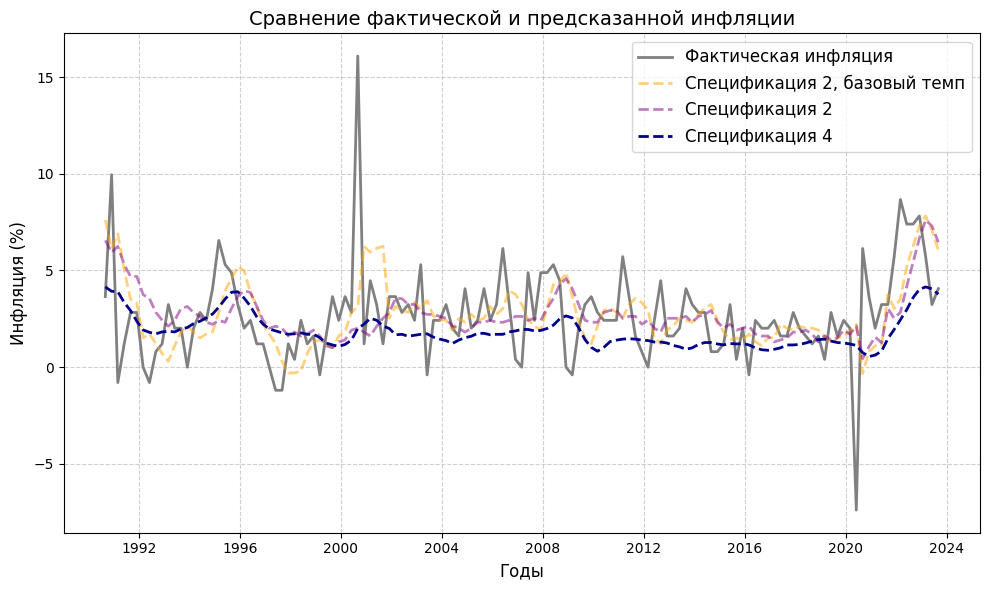

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(cpi_df_naive_4.cpi, label='Фактическая инфляция', color='gray', linewidth=2)
plt.plot(y_pred_spec_2, label='Спецификация 2, базовый темп', color='orange', linestyle='--', linewidth=2, alpha=0.5)
plt.plot(y_pred_spec_2_core, label='Спецификация 2', color='purple', linestyle='--', linewidth=2, alpha=0.5)
plt.plot(y_pred_spec_4, label='Спецификация 4', color='darkblue', linestyle='--', linewidth=2)

plt.title("Сравнение фактической и предсказанной инфляции", fontsize=14)
plt.xlabel("Годы", fontsize=12)
plt.ylabel("Инфляция (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

plt.tight_layout()

### Линейные модели: спецификация 1-2


*   y_pred_first - работает лучше
*   y_pred_first_core



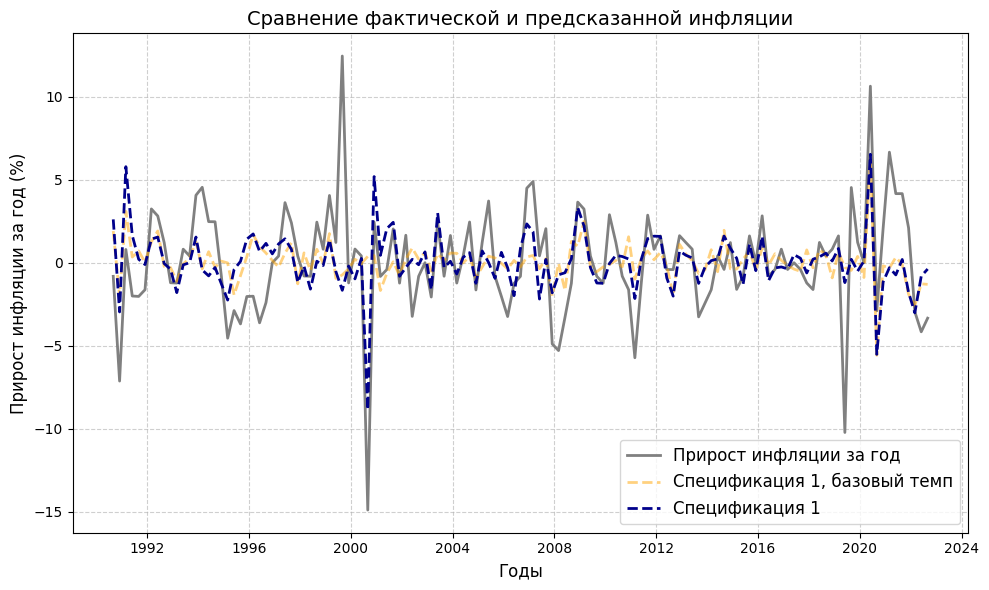

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(kek['target'], label='Прирост инфляции за год', color='gray', linewidth=2)

plt.plot(y_pred_first_core, label='Спецификация 1, базовый темп', color='orange', linestyle='--', linewidth=2, alpha = 0.5)
plt.plot(y_pred_first, label='Спецификация 1', color='darkblue', linestyle='--', linewidth=2)


plt.title("Сравнение фактической и предсказанной инфляции", fontsize=14)
plt.xlabel("Годы", fontsize=12)
plt.ylabel("Прирост инфляции за год (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

plt.tight_layout()

### Линейные модели: спецификация 5-7
* y_pred_5
* y_pred_6
* y_pred_7 -  работает лучше

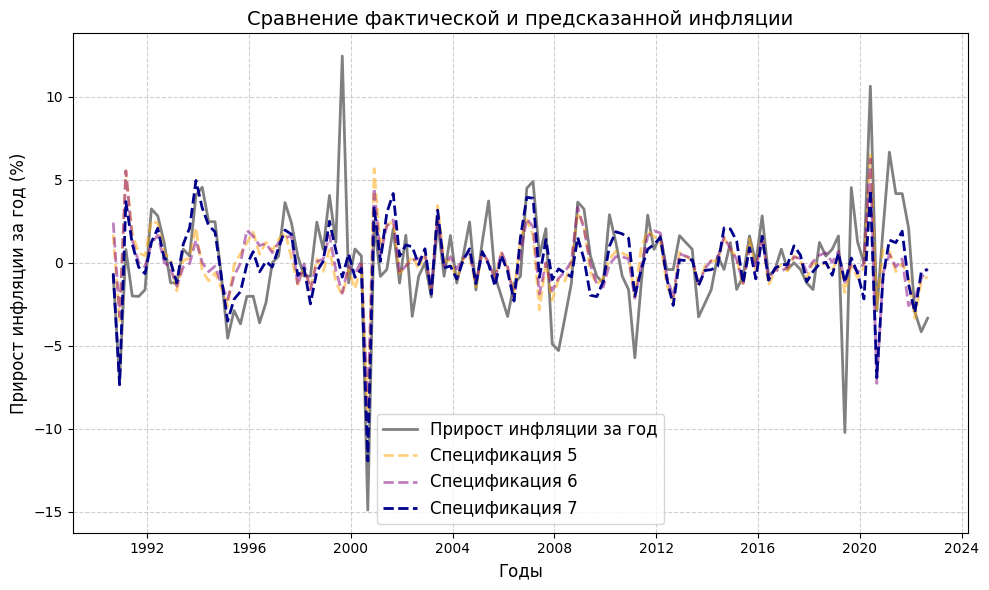

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(kek['target'], label='Прирост инфляции за год', color='gray', linewidth=2)
plt.plot(y_pred_5, label='Спецификация 5', color='orange', linestyle='--', linewidth=2, alpha = 0.5)
plt.plot(y_pred_6, label='Спецификация 6', color='purple', linestyle='--', linewidth=2, alpha = 0.5)
plt.plot(y_pred_7, label='Спецификация 7', color='darkblue', linestyle='--', linewidth=2)

plt.title("Сравнение фактической и предсказанной инфляции", fontsize=14)
plt.xlabel("Годы", fontsize=12)
plt.ylabel("Прирост инфляции за год (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

plt.tight_layout()

### Линейные модели: спецификация 3


*   y_pred_3



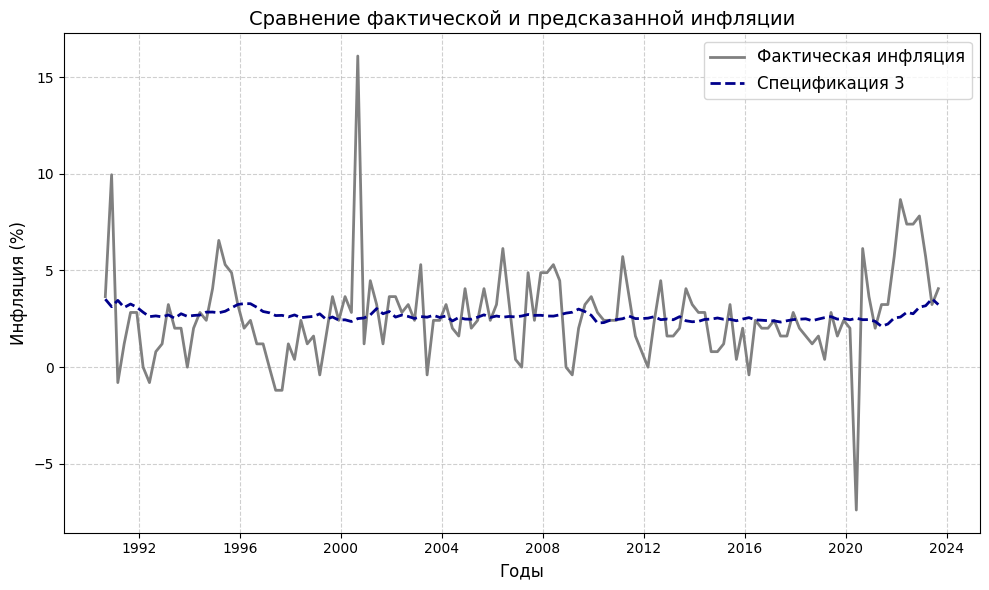

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(cpi_df_naive_4.cpi, label='Фактическая инфляция', color='gray', linewidth=2)
plt.plot(y_pred_3, label='Спецификация 3', color='darkblue', linestyle='--', linewidth=2)

plt.title("Сравнение фактической и предсказанной инфляции", fontsize=14)
plt.xlabel("Годы", fontsize=12)
plt.ylabel("Инфляция (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

plt.tight_layout()

### Номер 9

(10 баллов) Найдите в экономической литературе альтернативный метод прогнозирования инфляции. Приведите ссылку. Опишите его. Сравните с используемыми в данной работе методами.

**Статья:** Unobserved Components with Stochastic Volatility in
U.S. Inflation: Estimation and Signal Extraction

**Источник:** https://www.researchgate.net/publication/352199778_Unobserved_Components_with_Stochastic_Volatility_Simulation-based_Estimation_and_Signal_Extraction

**Метод:** UCSV с оценкой параметров через SML

-Unobserved Components with Stochastic Volatility

-Simulated Maximum Likelihood

## UCSV

UCSV-метод — это модель стохастической волатильности с ненаблюдаемой составляющей. Она имеет сходство с моделями случайного блуждания, но добавление случайной ненаблюдаемой переменной позволяет моделировать необъяснимые рыночные шоки.

UCSV-модели популярны в моделировании инфляции. Для их оценки используют метод, основанный на важности выборки, который на каждой итерации максимизации вычисляет вероятность с интегрированными ненаблюдаемыми компонентами.


### Инфляция $(y_t$) разлагается на две компоненты


$$
y_t = \pi_t + \psi_t
$$

### Трендовая компонента:
Трендовая компонента моделируется как случайное блуждание с изменяющейся во времени волатильностью:
$$
\pi_{t+1} = \pi_t + \eta_t, \quad \eta_t \sim N(0, Q_t), \quad Q_t = e^{h_{\pi,t}}
$$

### Переходная компонента:
Переходная компонента описывается авторегрессионным процессом:
$$
\psi_t = \phi \psi_{t-1} + \epsilon_t, \quad \epsilon_t \sim N(0, \Omega_t), \quad \Omega_t = e^{h_{y,t}}
$$

### Стохастическая волатильность:
Волатильности обеих компонент изменяются во времени и моделируются как случайное блуждание:
$$
h_{\pi,t+1} = h_{\pi,t} + \zeta_{\pi,t}, \quad \zeta_{\pi,t} \sim N(0, \sigma_\pi^2)
$$
$$
h_{y,t+1} = h_{y,t} + \zeta_{y,t}, \quad \zeta_{y,t} \sim N(0, \sigma_y^2)
$$


## Simulated Maximum Likelihood (SML):

SML  необходим, поскольку аналитическая функция правдоподобия для таких моделей недоступна из-за временной изменчивости волатильности (не линейная связь). SML позволяет интегрировать скрытые состояния (например, трендовые и переходные компоненты инфляции) через симуляции, используя важностное выборочное моделирование. Это делает метод подходящим для точной оценки сложных нелинейных моделей и анализа динамики инфляции, включая долгосрочные тренды и краткосрочные колебания.


Метод используется для оценки параметров модели $ (\phi, \sigma_\pi, \sigma_y, Q_t, \Omega_t)) $, так как аналитическая функция правдоподобия недоступна.

1. **Функция правдоподобия:**
$$
L(\theta | y_1, \dots, y_T) = \int p(y_1, \dots, y_T | H_T, \theta) p(H_T | \theta) dH_T
$$
где:
- $(\theta = (\phi, \sigma_\pi, \sigma_y))$ — параметры модели,
- $(H_T = \{h_{\pi,t}, h_{y,t}, \pi_t, \psi_t\}_{t=1}^T)$ — скрытые состояния.



2. **Аппроксимация через важностное выборочное моделирование (importance sampling):**
$$
L(\theta) \approx \frac{1}{M} \sum_{i=1}^M \frac{p(y_1, \dots, y_T | H_T^{(i)}, \theta) p(H_T^{(i)} | \theta)}{g(H_T^{(i)} | \theta)}
$$


где:
- $(H_T^{(i)}$) — симуляции скрытых состояний, $(g(H_T | \theta)$) — приближённая плотность, $(M$) — количество симуляций.

3. **Итерационная оптимизация:**
Максимизация функции правдоподобия по параметрам \(\theta\):
$$
\hat{\theta} = \arg \max_\theta \log L(\theta)
$$


## Сравнение с методов

Мы использовали простые методы прогнозирования инфляции, такие как регрессионный анализ на основе прошлых данных и "наивные" прогнозы, основанные на годовых изменениях индекса потребительских цен. Также исследуются модели с включением дополнительных переменных, таких как индекс экономической активности и инфляционные ожидания, что позволяет улучшить точность прогнозов в некоторых периодах.

В статье "Unobserved Components with Stochastic Volatility" применяются более сложная модель, как   модель стохастической волатильности с ненаблюдаемой составляющей (UCSV). Эта модели разлагает инфляцию на трендовую и временную составляющие, каждая из которых имеет свою волатильность. Для оценки таких моделей используется симуляционный метод максимального правдоподобия с важностным выбором, что позволяет учитывать изменения структуры данных и стохастические колебания, свойственные экономике(кризисы и изменения трендов).

В конечном итоге более сложный метод позволяет точнее прогнозировать динамику переменных, так как они подтверженны не четким законам, а определенной случайности.
